## Prerequisites

In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file, split_ids
from utils.preprocessing import create_batch_sequences
from models.models import build_model
from models.losses import MyWeightedBinaryCrossentropy, MyWeightedMeanSquaredError
from utils.evaluate import compare_events
from scipy.signal import find_peaks
np.random.seed(123)

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

## Get data

In [2]:
# Set root directory
ROOT_DIR = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"

# Split subjects into a train, validation, and test set
train_ids, val_ids, test_ids = split_ids(ROOT_DIR, by=["gender", "participant_type"])

In [3]:
# User settings
TRACKED_POINTS = ["left_ankle", "right_ankle", "left_shank", "right_shank"]
INCL_MAGN = False
NORMALIZE = True

In [4]:
# Get datasets
ds_train = load_dataset(ROOT_DIR, sub_ids=train_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_val = load_dataset(ROOT_DIR, sub_ids=val_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)
ds_test = load_dataset(ROOT_DIR, sub_ids=test_ids, tracked_points=TRACKED_POINTS, incl_magn=INCL_MAGN, normalize=NORMALIZE)

In [5]:
WIN_LEN = 400
STEP_LEN = 200
train_data, train_targets, ds_train_batches = create_batch_sequences(ds_train, win_len=WIN_LEN, step_len=STEP_LEN)
val_data, val_targets, ds_val_batches = create_batch_sequences(ds_val, win_len=WIN_LEN, step_len=STEP_LEN)

## Build model

In [6]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [7]:
NB_FILTERS = 32
KERNEL_SIZE = 5
DILATIONS = [1, 2]
PADDING = "same"

In [8]:
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

In [9]:
kwargs = {
    "nb_filters": NB_FILTERS,
    "kernel_size": KERNEL_SIZE,
    "dilations": DILATIONS,
    "padding": PADDING,
}

In [10]:
INPUT_DIM = train_data.shape[-1]
CLASS_NAMES = list(train_targets.keys())
# LOSS_FN = keras.losses.MeanSquaredError()
LOSS_FN = MyWeightedMeanSquaredError(0.05)

In [31]:
import tensorflow as tf
import tensorflow.keras.backend as K
class MyWeightedMeanSquaredError(tf.keras.losses.Loss):
    def __init__(self, weights=0.01):
        super().__init__()
        self.weights = weights
    
    def call(self, y_true, y_pred):
        loss = K.mean(K.mean(K.square(y_pred - y_true)) * (y_true + self.weights), axis=-1)
        return loss

In [32]:
model = build_model(
    input_dim=INPUT_DIM, 
    class_names=CLASS_NAMES, 
    loss_fn=MyWeightedMeanSquaredError(0.01), 
    **kwargs
)
model.summary()

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 6)]    0           []                               
                                                                                                  
 tcn_layer (TCN)                (None, None, 32)     17184       ['inputs[0][0]']                 
                                                                                                  
 initial_contact (Dense)        (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                                  
 final_contact (Dense)          (None, None, 1)      33          ['tcn_layer[0][0]']              
                                                                                          

In [33]:
history = model.fit(
    x=train_data, 
    y=train_targets, 
    batch_size=16, 
    epochs=10, 
    validation_data=(val_data, val_targets),
    shuffle=True,
    callbacks=CALLBACKS
)

Epoch 1/10
211/211 [==============================] - 2s 7ms/step - loss: 0.0041 - initial_contact_loss: 0.0025 - final_contact_loss: 0.0016 - val_loss: 0.0016 - val_initial_contact_loss: 7.2712e-04 - val_final_contact_loss: 8.5729e-04
Epoch 2/10
211/211 [==============================] - 1s 6ms/step - loss: 9.7954e-04 - initial_contact_loss: 4.8626e-04 - final_contact_loss: 4.9328e-04 - val_loss: 0.0011 - val_initial_contact_loss: 5.4725e-04 - val_final_contact_loss: 5.7728e-04
Epoch 3/10
211/211 [==============================] - 1s 6ms/step - loss: 8.1623e-04 - initial_contact_loss: 4.1237e-04 - final_contact_loss: 4.0386e-04 - val_loss: 0.0010 - val_initial_contact_loss: 5.1265e-04 - val_final_contact_loss: 5.2441e-04
Epoch 4/10
211/211 [==============================] - 1s 6ms/step - loss: 7.4106e-04 - initial_contact_loss: 3.7745e-04 - final_contact_loss: 3.6362e-04 - val_loss: 0.0010 - val_initial_contact_loss: 5.0071e-04 - val_final_contact_loss: 5.1655e-04
Epoch 5/10
211/211 [

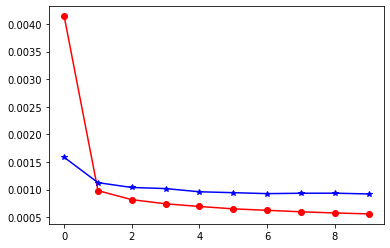

In [34]:
fig, ax = plt.subplots(1, 1)
ax.plot(history.history["loss"], 'ro-', label='training')
ax.plot(history.history["val_loss"], 'b*-', label="validation")
plt.show()

### Evaluate on test set

In [35]:
from utils.plot_utils import plot_predictions

sub-pp136_task-walkPreferred ... right_shank


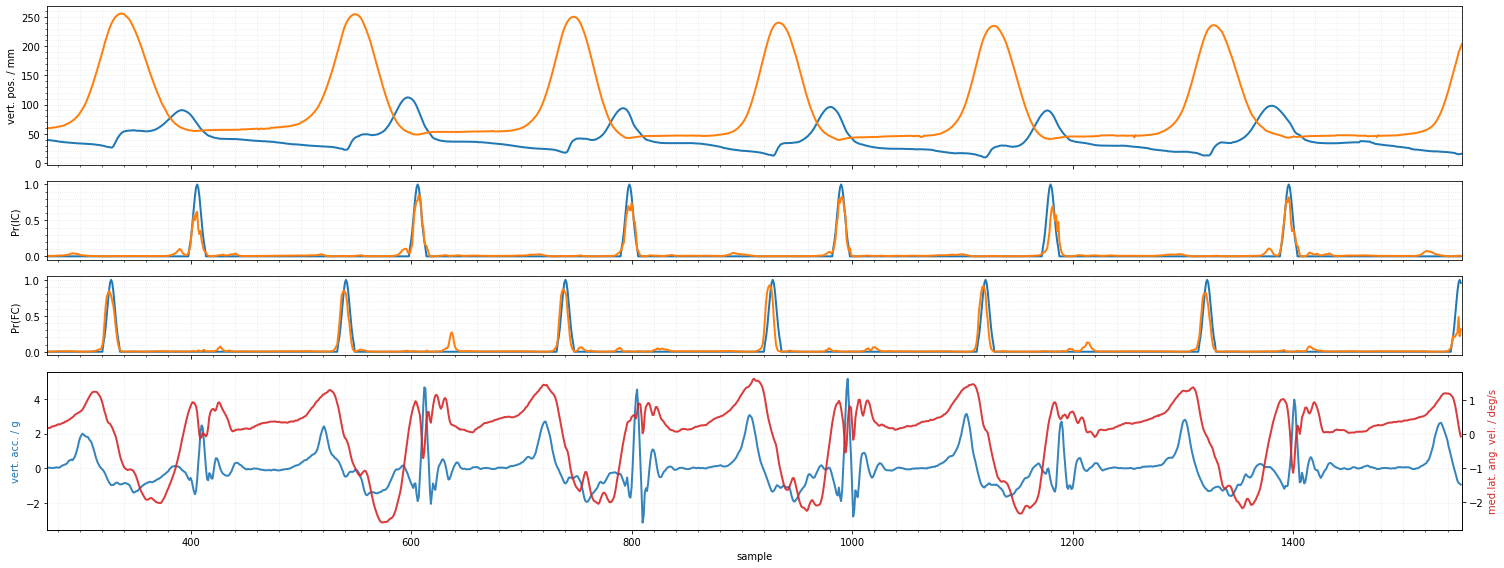

In [38]:
ix_instance = np.random.choice(len(ds_test), size=1, replace=False)[0]
print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
predictions = model.predict(np.expand_dims(ds_test[ix_instance]["data"], axis=0))
plot_predictions(
    path=ROOT_DIR,
    data=ds_test[ix_instance]["data"],
    targets=ds_test[ix_instance]["targets"],
    predictions=predictions,
    filename_prefix=ds_test[ix_instance]["filename_prefix"],
    tracked_point=ds_test[ix_instance]["tracked_point"]
)
# for ix_instance in range(len(ds_test[51:52])):
#     print(f"{ds_test[ix_instance]['filename_prefix']:s} ... {ds_test[ix_instance]['tracked_point']:s}")
#     predictions = model.predict(np.expand_dims(ds_test[ix_instance]["data"], axis=0))
#     plot_predictions(
#         path=ROOT_DIR,
#         data=ds_test[ix_instance]["data"],
#         targets=ds_test[ix_instance]["targets"],
#         predictions=predictions,
#         filename_prefix=ds_test[ix_instance]["filename_prefix"],
#         tracked_point=ds_test[ix_instance]["tracked_point"]
#     )